# Predicting Heart Disease: DSCI 100 Group Project Report  (Group 23)

### Introduction:

Cardiovascular diseases (CVDs), or heart diseases, encompasses a range of medical conditions that affect the heart and blood vessels. Worldwide, CVDs are the leading cause of death with nearly 18 million deaths a year (World Health Organization, 2023). Early detection is key to treatment, prevention, and management of heart disease; this data analysis aims to create an algorithm which can be used to assist with this process.

The dataset used is from: https://archive.ics.uci.edu/dataset/45/heart+disease. The data was published in 1988 and the dataset we are using is the one specifically collected in Cleveland. The dataset consists of 303 observations and 14 variables.

The question we aim to address is: **can we predict if a patient has heart disease based on their age, resting blood pressure, serum cholesterol, and maximum resting heart rate?**

We will use the k-nearest neighbor classification model to predict heart disease.

### Methods & Results:

First we load in the required libraries into this Jupyter notebook so that we can use it to edit, wrangle and visualize any data. We also import the `RColorBrewer` library so that we can make our plots color-blind friendly.

In [1]:
library(tidyverse)
library(RColorBrewer)
library(tidymodels)
library(repr)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

We downloaded the dataset from Kaggle and uploaded it to a remote repistory (GitHub). This makes the dataset accessible and reproducible. The code below downloads the dataset from the remote repository into this notebook which is the local repository. Then we read the csv file that is downloaded.

In [2]:
#These lines of code bring the data into R and make it into a table showing the first 5 rows
download.file("https://raw.githubusercontent.com/Aamitoz-Sharma/Group_23_project/main/heart.csv", "heart_data.csv") #downloading file
heart_data <- read_csv("heart_data.csv")
head(heart_data)


Rows: 918 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope
dbl (7): Age, RestingBP, Cholesterol, FastingBS, MaxHR, Oldpeak, HeartDisease

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0


Table 1: Downloaded dataset

Next, we wrangle the dataset. First we use `select` to only obtain the columns that we are interested in i.e. the categorical variable we want to predict and the predictors. Then we use `mutate` to change the data type of the variable that we want to predict (`HeartDisease`) into a categorical variable(`fct`) so that we can use it in our k-nn classification model. We also change the numbers in `HeartDisease` from 0 and 1 to "yes" and "no" so that it is easier to understand. We also make sure to remove the rows with zero values in `RestingBP`, `Cholesterol` and, `MaxHR` as this most likely means that the data for these were missing or unavailable.

In [3]:
#This set of data will select the data points we are interested in Age, Resting blood pressure, Cholesterol, Max heart rate and Heart Disease
heart <- heart_data |> 
    select(Age, RestingBP, Cholesterol, MaxHR, HeartDisease) |>
#This line changes the Heart Disease variable from a continous quantitative variable(dbl) to a categorical variable(fct)
    mutate(HeartDisease = as_factor(HeartDisease)) |>
#This line changes the factor variables from 0 to no and 1 to yes
    mutate(HeartDisease = fct_recode(HeartDisease, "yes" = "1", "no" = "0")) |>
    filter(RestingBP != 0, Cholesterol != 0, MaxHR != 0)
head(heart)

Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
40,140,289,172,no
49,160,180,156,yes
37,130,283,98,no
48,138,214,108,yes
54,150,195,122,no
39,120,339,170,no


Table 2: Wrangled dataset

Now, we will calculate the mean of each predictor grouped by `HeartDisease` to get some sort of idea about our predictors.

In [4]:
mean_predictors <- group_by(heart, HeartDisease) |>
    summarize(across(Age:MaxHR, mean))

mean_predictors

HeartDisease,Age,RestingBP,Cholesterol,MaxHR
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
no,50.17179,130.1641,238.7692,149.0590
yes,55.85112,136.1545,251.0618,130.5506


Table 3: Mean of all predictors grouped by `HeartDisease`

From Table 3, we can see that the mean of all the predictors for each categorical variable. We get a rough idea that predictors such as `Cholesterol` and `MaxHR` are going to be good predictors when compared to `RestingBP`. However, it is important to note that this idea may not be accurate since the data is neither scaled nor centered yet and hence one predictor may be more important than the other.

The following code splits the dataset into training and testing data as this allows us to know how good our model is and if it is making major mistakes while predicting. We make sure to set the seed so that this code is reproducible.

In [5]:
set.seed(1) #setting seed to make the code reproducible
heart_split <- initial_split(heart, prop = 0.75, strata = HeartDisease) #splitting into training and testing data.
heart_train <- training(heart_split)
heart_test <- testing(heart_split)


In [6]:
head(heart_train)

Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
40,140,289,172,no
37,130,283,98,no
39,120,204,145,no
54,120,273,150,no
43,120,201,165,no
43,100,223,142,no


Table 4: Training dataset

In [7]:
head(heart_test)

Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
54,150,195,122,no
39,120,339,170,no
45,130,237,170,no
54,110,208,142,no
48,120,284,120,no
37,130,211,142,no


Table 5: Testing dataset

We want to visualize the number of each categorical variables that are present in the training dataset so that we get a rough idea about their proportion. Therefore, we make a bar chart to compare them.

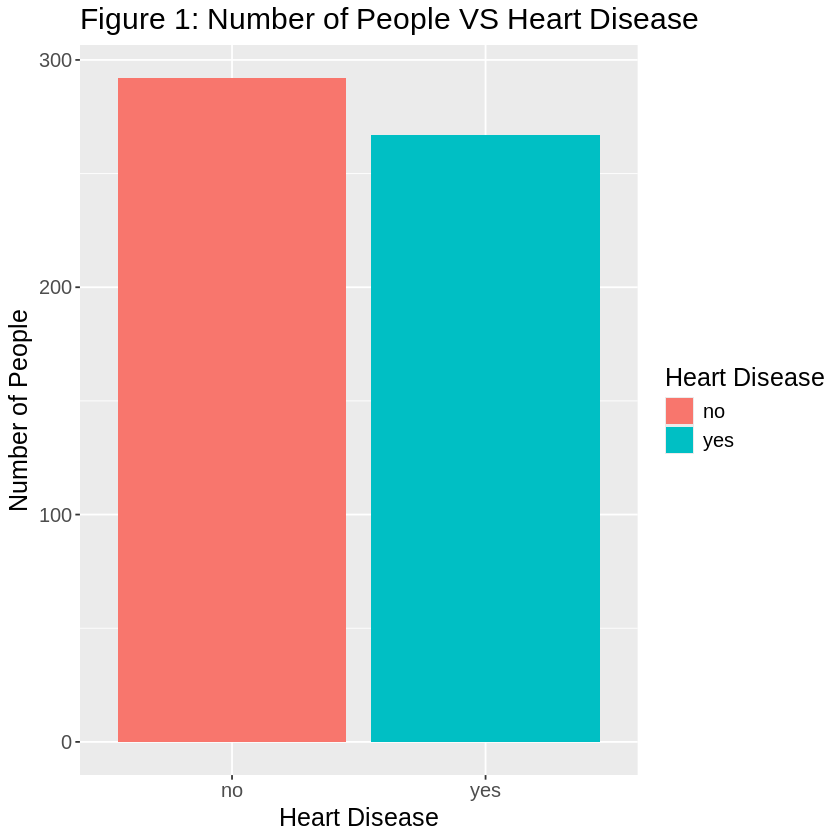

In [8]:
options(repr.plot.width = 7, repr.plot.height = 7) 
heart_disease_plot <- heart_train |>
    ggplot(aes(x = HeartDisease, fill = HeartDisease)) +
    geom_bar() +
    xlab("Heart Disease") +
    ylab("Number of People") +
    labs(fill = "Heart Disease") +
    ggtitle("Figure 1: Number of People VS Heart Disease") +
    theme(text = element_text(size = 15))

heart_disease_plot

Next, we need to build a model for k-nearest neighbor (k-nn) classification for each set of two categorical variables. To do this, we first set the seed again so that the nearest neighbors while tuning are always the same and hence this code is reproducible. Then, we determine the best k-value by performing 10-fold cross-validation for each set and using a workflow. We also make sure to scale and center our predictors so that each predictor gets its necessary importance. We pull the best k-value which will be the one with the most accuracy.

In [9]:
set.seed(1) #setting seed
# Finding the best k for predicting heart disease using Age and Resting Blood pressure as predictors
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_vfold <- vfold_cv(heart_train, v = 10, strata = HeartDisease)

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

heart_recipe_Age_RestingBP <- recipe(HeartDisease ~ Age + RestingBP,data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

Age_RestingBP_best_k <- workflow() |>
    add_recipe(heart_recipe_Age_RestingBP) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")|>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
Age_RestingBP_best_k

[1] 81

In [10]:
# Finding the best k for predicting heart disease using Age and Cholesterol as predictors
heart_recipe_Age_Cholesterol <- recipe(HeartDisease ~ Age + Cholesterol,data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

Age_Cholesterol_best_k <- workflow() |>
    add_recipe(heart_recipe_Age_Cholesterol) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")|>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
Age_Cholesterol_best_k

[1] 11

In [11]:
# Finding the best k for predicting heart disease using Age and MaxHR as predictors
heart_recipe_Age_MaxHR <- recipe(HeartDisease ~ Age + MaxHR,data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

Age_MaxHR_best_k <- workflow() |>
    add_recipe(heart_recipe_Age_MaxHR) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")|>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
Age_MaxHR_best_k 

[1] 71

In [12]:
# Finding the best k for predicting heart disease using MaxHR and Cholesterol as predictors
heart_recipe_MaxHR_Cholesterol <- recipe(HeartDisease ~ MaxHR + Cholesterol,data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

MaxHR_Cholesterol_best_k <- workflow() |>
    add_recipe(heart_recipe_MaxHR_Cholesterol) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")|>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
MaxHR_Cholesterol_best_k 

[1] 51

In [13]:
# Finding the best k for predicting heart disease using MaxHR and RestingBP
heart_recipe_RestingBP_MaxHR <- recipe(HeartDisease ~ MaxHR + RestingBP,data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

RestingBP_MaxHR_best_k <- workflow() |>
    add_recipe(heart_recipe_RestingBP_MaxHR) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")|>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
RestingBP_MaxHR_best_k 

[1] 26

In [14]:
# Finding the best k for predicting heart disease using Cholesterol and RestingBP as predictors
heart_recipe_RestingBP_Cholesterol <- recipe(HeartDisease ~ Cholesterol + RestingBP,data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

RestingBP_Cholesterol_best_k <- workflow() |>
    add_recipe(heart_recipe_RestingBP_Cholesterol) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")|>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
RestingBP_Cholesterol_best_k 

[1] 26

Now, we use the best k-value that we found above in a new workflow. Then, using this workflow that we trained using the training dataset, we predict `HeartDisease` for the data present in the testing dataset. We use the recipe that we already scaled and centered in our workflow to ensure that each predictor gets its necessary importance. We also want to visualize the distribution using a scatterplot. We do this for each set.

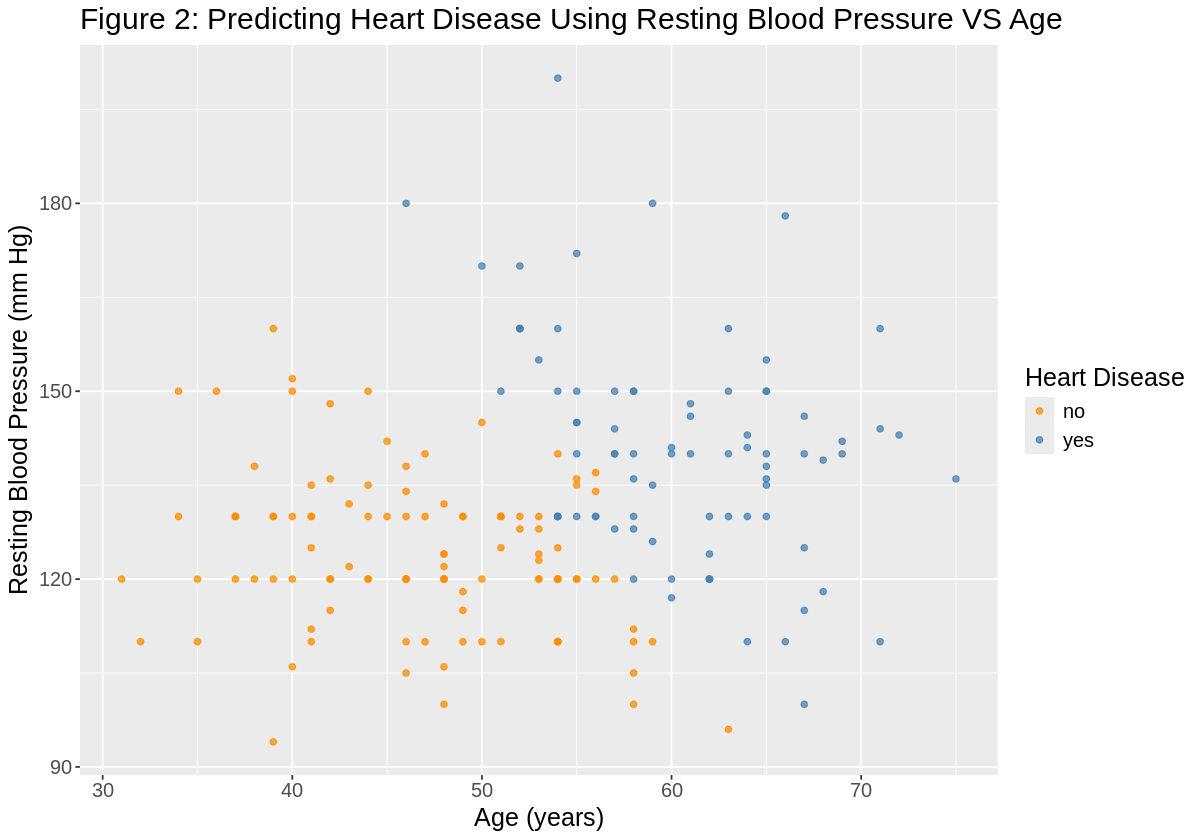

In [15]:
options(repr.plot.width = 10, repr.plot.height = 7) 
heart_spec_Age_RestingBP <- nearest_neighbor(weight_func = "rectangular", neighbors = Age_RestingBP_best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_fit_Age_RestingBP <- workflow() |>
        add_recipe(heart_recipe_Age_RestingBP) |>
        add_model(heart_spec_Age_RestingBP) |>
        fit(data = heart_train)

Heart_preds_Age_RestingBP <- heart_fit_Age_RestingBP |>
        predict(heart_test) |>
        bind_cols(heart_test)

heart_plot_Age_RestingBP <- ggplot() +
  geom_point(data = Heart_preds_Age_RestingBP,
             mapping = aes(x = Age,
                           y = RestingBP,
                           color = .pred_class),
             alpha = 0.75) +
  labs(color = "Heart Disease",
       x = "Age (years)",
       y = "Resting Blood Pressure (mm Hg)") +
  ggtitle("Figure 2: Predicting Heart Disease Using Resting Blood Pressure VS Age") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 15))

heart_plot_Age_RestingBP

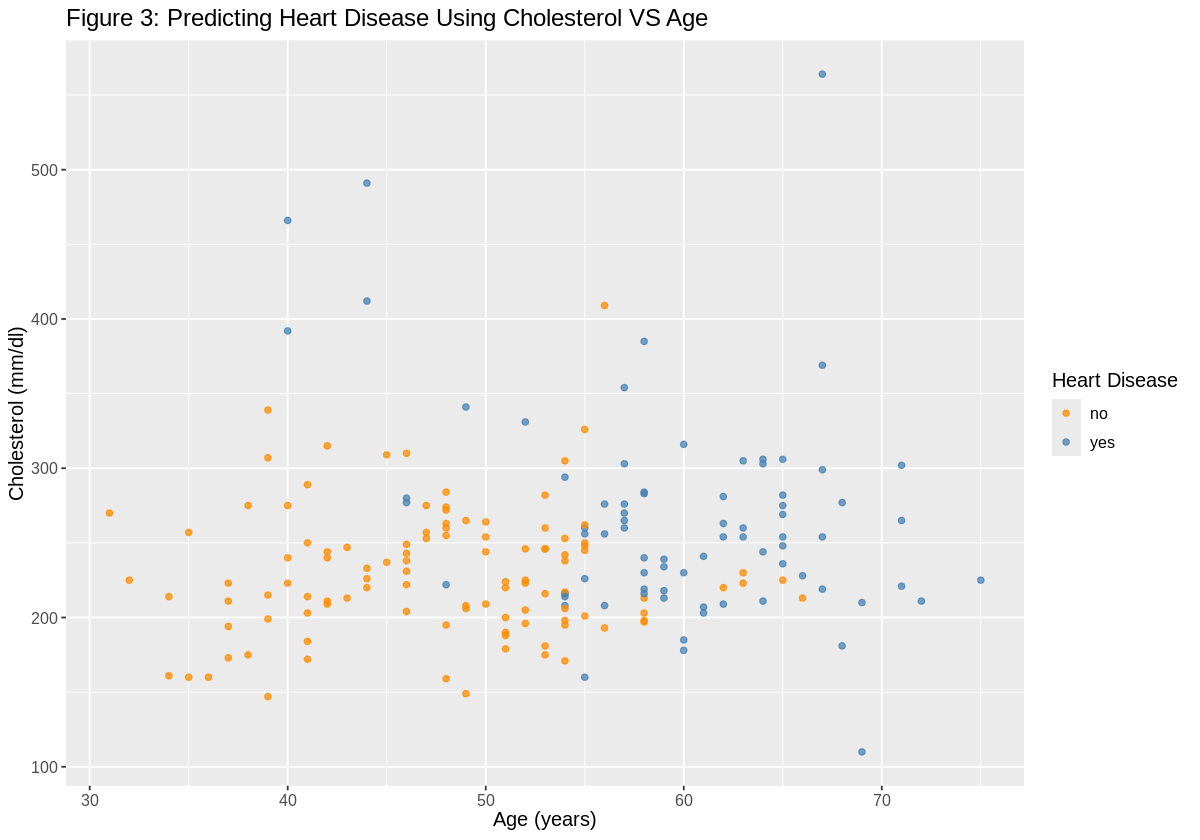

In [16]:
options(repr.plot.width = 10, repr.plot.height = 7) 
heart_spec_Age_Cholesterol <- nearest_neighbor(weight_func = "rectangular", neighbors = Age_Cholesterol_best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_fit_Age_Cholesterol <- workflow() |>
        add_recipe(heart_recipe_Age_Cholesterol) |>
        add_model(heart_spec_Age_Cholesterol) |>
        fit(data = heart_train)

Heart_preds_Age_Cholesterol <- heart_fit_Age_Cholesterol |>
        predict(heart_test) |>
        bind_cols(heart_test)

heart_plot_Age_Cholesterol <- ggplot() +
  geom_point(data = Heart_preds_Age_Cholesterol,
             mapping = aes(x = Age,
                           y = Cholesterol,
                           color = .pred_class),
             alpha = 0.75) +
  labs(color = "Heart Disease",
       x = "Age (years)",
       y = "Cholesterol (mm/dl)") +
  ggtitle("Figure 3: Predicting Heart Disease Using Cholesterol VS Age") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 12))

heart_plot_Age_Cholesterol

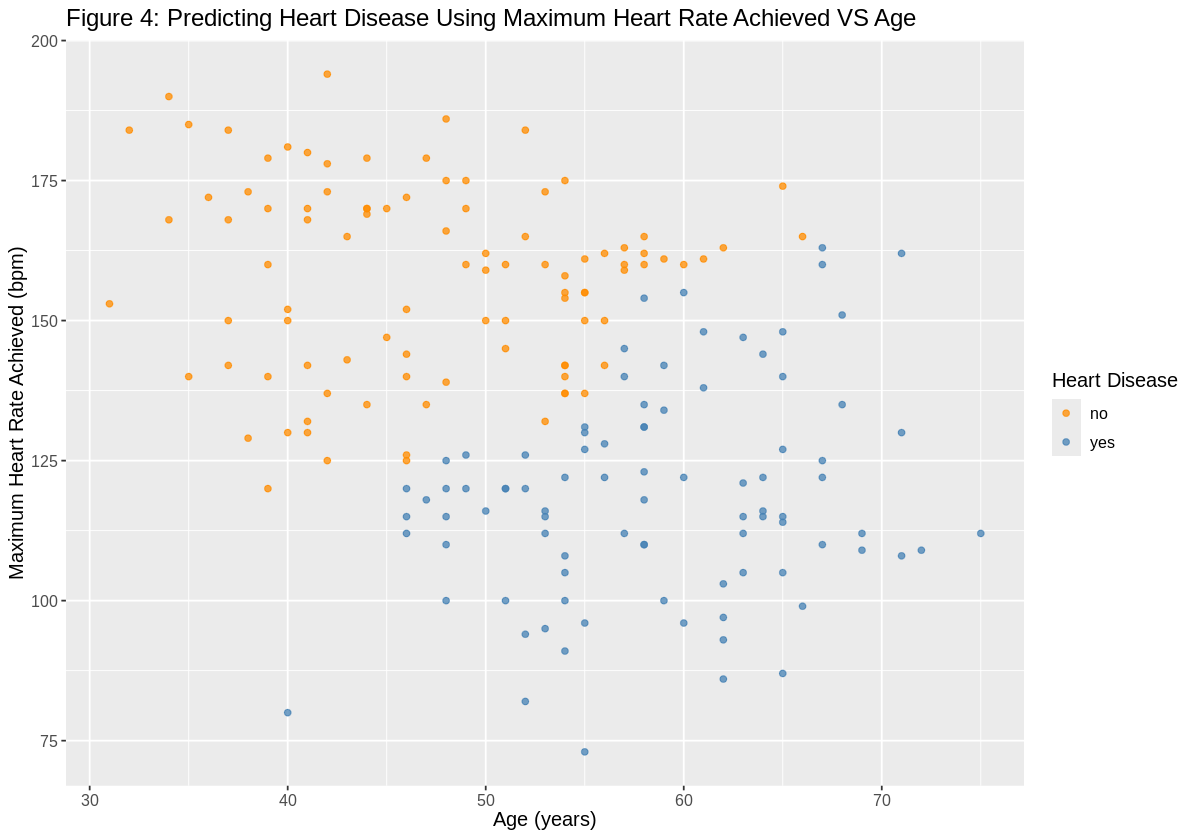

In [17]:
options(repr.plot.width = 10, repr.plot.height = 7) 
heart_spec_Age_MaxHR <- nearest_neighbor(weight_func = "rectangular", neighbors = Age_MaxHR_best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_fit_Age_MaxHR <- workflow() |>
        add_recipe(heart_recipe_Age_MaxHR) |>
        add_model(heart_spec_Age_MaxHR) |>
        fit(data = heart_train)

Heart_preds_Age_MaxHR <- heart_fit_Age_MaxHR |>
        predict(heart_test) |>
        bind_cols(heart_test)

heart_plot_Age_MaxHR <- ggplot() +
  geom_point(data = Heart_preds_Age_MaxHR,
             mapping = aes(x = Age,
                           y = MaxHR,
                           color = .pred_class),
             alpha = 0.75) +
  labs(color = "Heart Disease",
       x = "Age (years)",
       y = "Maximum Heart Rate Achieved (bpm)") +
  ggtitle("Figure 4: Predicting Heart Disease Using Maximum Heart Rate Achieved VS Age") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 12))

heart_plot_Age_MaxHR

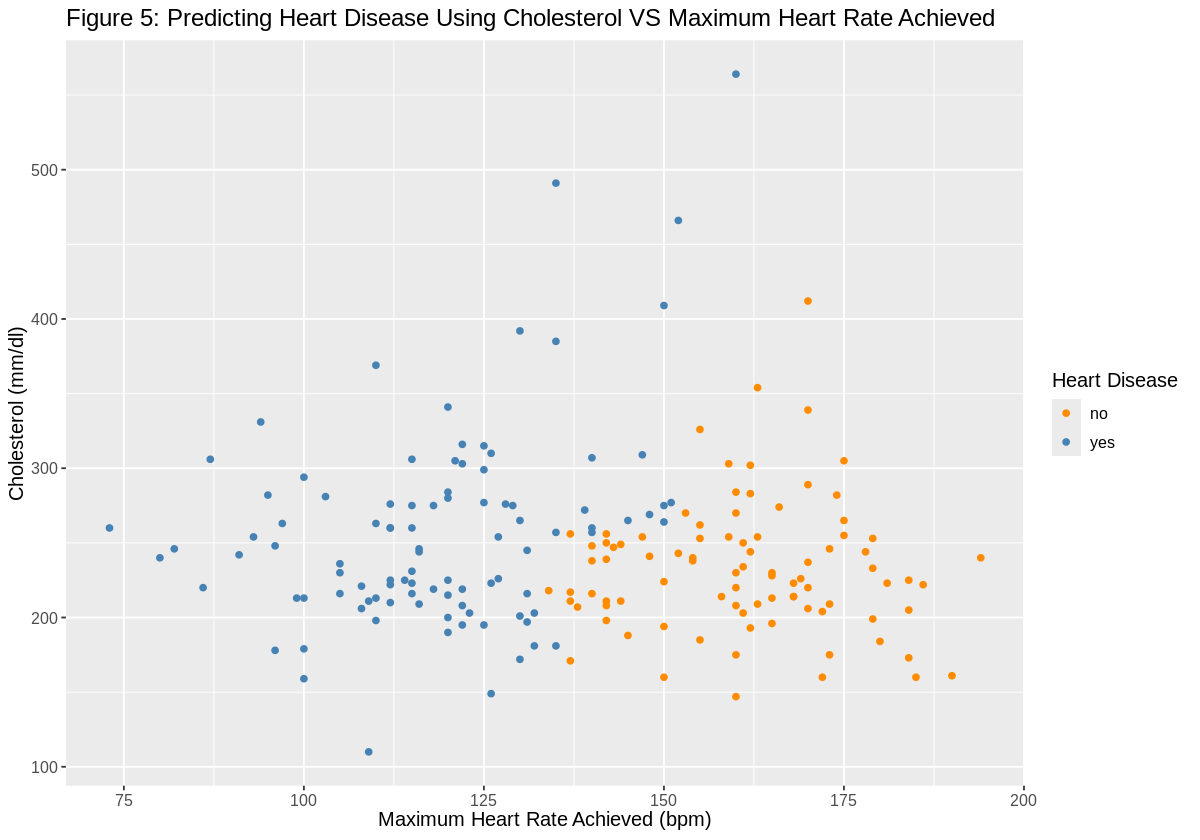

In [18]:
options(repr.plot.width = 10, repr.plot.height = 7) 
heart_spec_MaxHR_Cholesterol <- nearest_neighbor(weight_func = "rectangular", neighbors = MaxHR_Cholesterol_best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_fit_Age_MaxHR <- workflow() |>
        add_recipe(heart_recipe_MaxHR_Cholesterol) |>
        add_model(heart_spec_MaxHR_Cholesterol) |>
        fit(data = heart_train)

Heart_preds_MaxHR_Cholesterol <- heart_fit_Age_MaxHR |>
        predict(heart_test) |>
        bind_cols(heart_test)

heart_plot_MaxHR_Cholesterol <- ggplot() +
  geom_point(data = Heart_preds_MaxHR_Cholesterol,
             mapping = aes(x = MaxHR,
                           y = Cholesterol,
                           color = .pred_class)) +
  labs(color = "Heart Disease",
       x = "Maximum Heart Rate Achieved (bpm)",
       y = "Cholesterol (mm/dl)") +
  ggtitle("Figure 5: Predicting Heart Disease Using Cholesterol VS Maximum Heart Rate Achieved") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 12))

heart_plot_MaxHR_Cholesterol

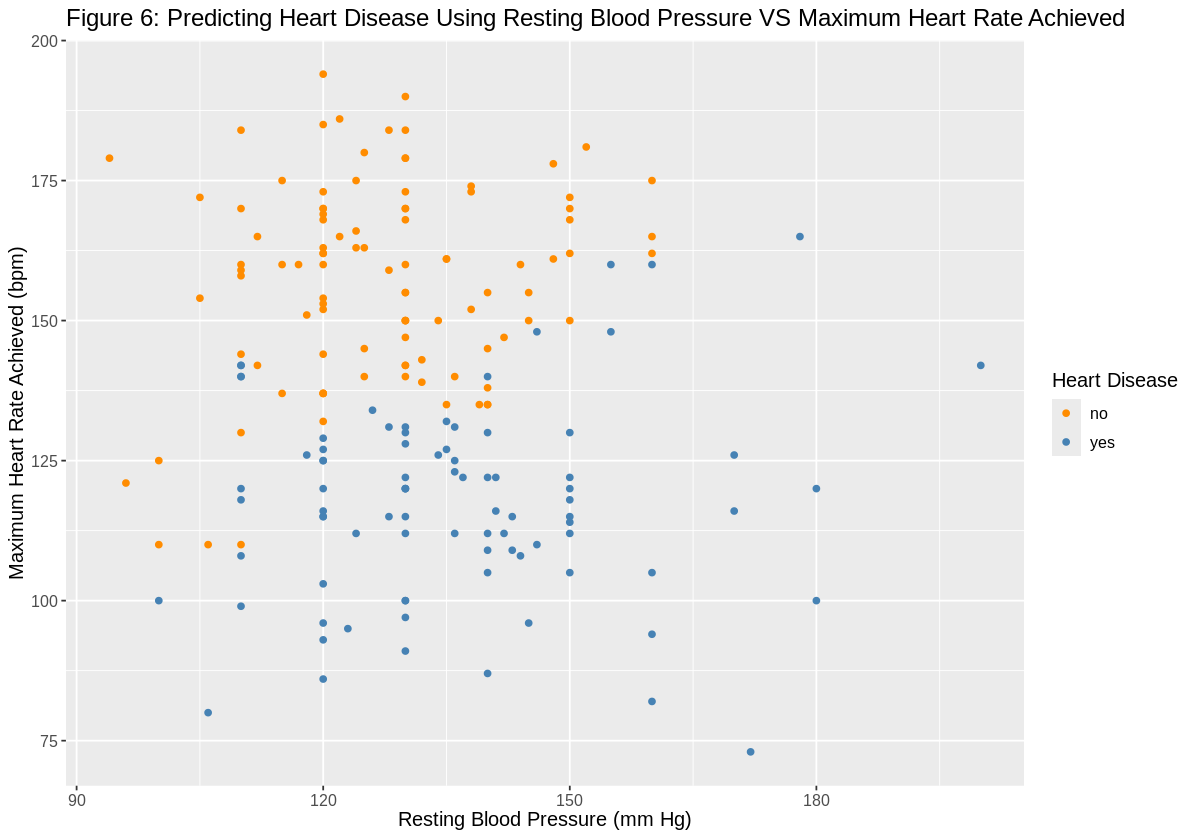

In [19]:
options(repr.plot.width = 10, repr.plot.height = 7) 
heart_spec_RestingBP_MaxHR <- nearest_neighbor(weight_func = "rectangular", neighbors = RestingBP_MaxHR_best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_fit_RestingBP_MaxHR <- workflow() |>
        add_recipe(heart_recipe_RestingBP_MaxHR) |>
        add_model(heart_spec_RestingBP_MaxHR) |>
        fit(data = heart_train)

Heart_preds_RestingBP_MaxHR <- heart_fit_RestingBP_MaxHR |>
        predict(heart_test) |>
        bind_cols(heart_test)

heart_plot_RestingBP_MaxHR <- ggplot() +
  geom_point(data = Heart_preds_RestingBP_MaxHR,
             mapping = aes(x = RestingBP,
                           y = MaxHR,
                           color = .pred_class)) +
  labs(color = "Heart Disease",
       x = "Resting Blood Pressure (mm Hg)",
       y = "Maximum Heart Rate Achieved (bpm)") +
  ggtitle("Figure 6: Predicting Heart Disease Using Resting Blood Pressure VS Maximum Heart Rate Achieved") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 12))

heart_plot_RestingBP_MaxHR

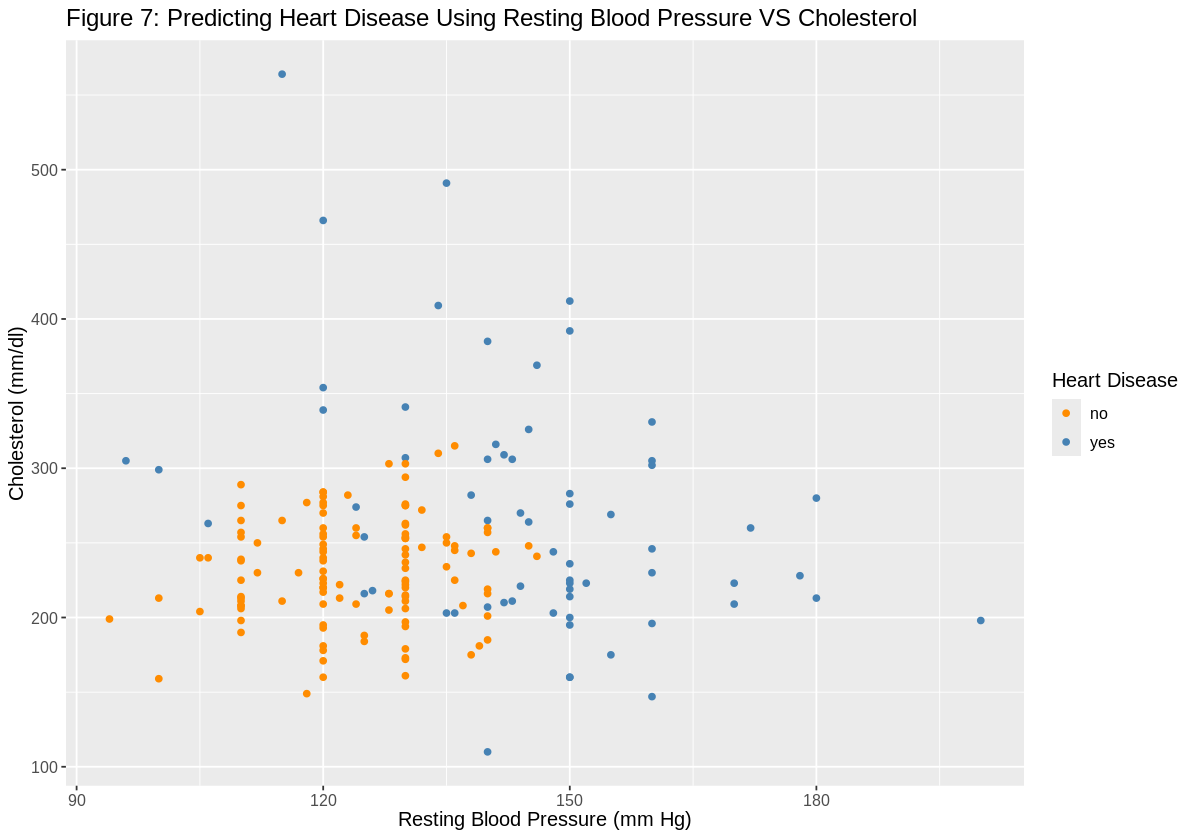

In [20]:
options(repr.plot.width = 10, repr.plot.height = 7) 
heart_spec_RestingBP_Cholesterol <- nearest_neighbor(weight_func = "rectangular", neighbors = RestingBP_Cholesterol_best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_fit_RestingBP_Cholesterol <- workflow() |>
        add_recipe(heart_recipe_RestingBP_Cholesterol) |>
        add_model(heart_spec_RestingBP_Cholesterol) |>
        fit(data = heart_train)

Heart_preds_RestingBP_Cholesterol <- heart_fit_RestingBP_Cholesterol |>
        predict(heart_test) |>
        bind_cols(heart_test)

heart_plot_RestingBP_Cholesterol <- ggplot() +
  geom_point(data = Heart_preds_RestingBP_Cholesterol,
             mapping = aes(x = RestingBP,
                           y = Cholesterol,
                           color = .pred_class)) +
  labs(color = "Heart Disease",
       x = "Resting Blood Pressure (mm Hg)",
       y = "Cholesterol (mm/dl)") +
  ggtitle("Figure 7: Predicting Heart Disease Using Resting Blood Pressure VS Cholesterol") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 12))
heart_plot_RestingBP_Cholesterol

Next, we will calculate the accuracies, recall and precisions for each model to determine which of these are good predictors and which of these are not. We first check which label comes first.

In [21]:
Heart_preds_Age_RestingBP |> pull(HeartDisease) |> levels()
Heart_preds_Age_Cholesterol |> pull(HeartDisease) |> levels()
Heart_preds_Age_MaxHR |> pull(HeartDisease) |> levels()
Heart_preds_MaxHR_Cholesterol |> pull(HeartDisease) |> levels()
Heart_preds_RestingBP_MaxHR |> pull(HeartDisease) |> levels()
Heart_preds_RestingBP_Cholesterol |> pull(HeartDisease) |> levels()

[1] "no"  "yes"

[1] "no"  "yes"

[1] "no"  "yes"

[1] "no"  "yes"

[1] "no"  "yes"

[1] "no"  "yes"

We can see that `no` comes before `yes` for all the sets. We know that `yes` is more important than `no` because it is better to wrongly predict that a person has a heart disease compared to wrongly predicting a person does not have a heart disease. Therefore, we use `event_level = "second"` while calculating recall and precision.

In [22]:
accuracy_Age_RestingBP <- Heart_preds_Age_RestingBP |>
    metrics(truth = HeartDisease, estimate = .pred_class) |>
    bind_rows(recall(Heart_preds_Age_RestingBP, truth=HeartDisease, estimate=.pred_class, event_level="second")) |>
    bind_rows(precision(Heart_preds_Age_RestingBP, truth=HeartDisease, estimate=.pred_class)) |>
    select(.metric, .estimate) |>
    filter(.metric != "kap")

accuracy_Age_Cholesterol <- Heart_preds_Age_Cholesterol |>
    metrics(truth = HeartDisease, estimate = .pred_class) |>
    bind_rows(recall(Heart_preds_Age_Cholesterol, truth=HeartDisease, estimate=.pred_class, event_level="second")) |>
    bind_rows(precision(Heart_preds_Age_Cholesterol, truth=HeartDisease, estimate=.pred_class)) |>
    select(.metric, .estimate) |>
    filter(.metric != "kap")

accuracy_Age_MaxHR <- Heart_preds_Age_MaxHR |>
    metrics(truth = HeartDisease, estimate = .pred_class) |>
    bind_rows(recall(Heart_preds_Age_MaxHR, truth=HeartDisease, estimate=.pred_class, event_level="second")) |>
    bind_rows(precision(Heart_preds_Age_MaxHR, truth=HeartDisease, estimate=.pred_class)) |>
    select(.metric, .estimate) |>
    filter(.metric != "kap")

accuracy_MaxHR_Cholesterol <- Heart_preds_MaxHR_Cholesterol |>
    metrics(truth = HeartDisease, estimate = .pred_class) |>
    bind_rows(recall(Heart_preds_MaxHR_Cholesterol, truth=HeartDisease, estimate=.pred_class, event_level="second")) |>
    bind_rows(precision(Heart_preds_MaxHR_Cholesterol, truth=HeartDisease, estimate=.pred_class)) |>
    select(.metric, .estimate) |>
    filter(.metric != "kap")

accuracy_RestingBP_MaxHR <- Heart_preds_RestingBP_MaxHR |>
    metrics(truth = HeartDisease, estimate = .pred_class) |>
    bind_rows(recall(Heart_preds_RestingBP_MaxHR, truth=HeartDisease, estimate=.pred_class, event_level="second")) |>
    bind_rows(precision(Heart_preds_RestingBP_MaxHR, truth=HeartDisease, estimate=.pred_class)) |>
    select(.metric, .estimate) |>
    filter(.metric != "kap")


accuracy_RestingBP_Cholesterol <- Heart_preds_RestingBP_Cholesterol |>
    metrics(truth = HeartDisease, estimate = .pred_class) |>
    bind_rows(recall(Heart_preds_RestingBP_Cholesterol, truth=HeartDisease, estimate=.pred_class, event_level="second")) |>
    bind_rows(precision(Heart_preds_RestingBP_Cholesterol, truth=HeartDisease, estimate=.pred_class)) |>
    select(.metric, .estimate) |>
    filter(.metric != "kap")


In [23]:
accuracy_Age_RestingBP

.metric,.estimate
<chr>,<dbl>
accuracy,0.6256684
recall,0.5617978
precision,0.6320755


Table 6: Age and resting blood pressure performance metrics

In [24]:
accuracy_Age_Cholesterol

.metric,.estimate
<chr>,<dbl>
accuracy,0.6631016
recall,0.5842697
precision,0.6605505


Table 7: Age and cholesterol performance metrics

In [25]:
accuracy_Age_MaxHR

.metric,.estimate
<chr>,<dbl>
accuracy,0.6844920
recall,0.6741573
precision,0.7010309


Table 8: Age and heart rate performance metrics

In [26]:
accuracy_MaxHR_Cholesterol

.metric,.estimate
<chr>,<dbl>
accuracy,0.6737968
recall,0.7078652
precision,0.7078652


Table 9: Heart rate and cholesterol performance metrics

In [27]:
accuracy_RestingBP_MaxHR

.metric,.estimate
<chr>,<dbl>
accuracy,0.6844920
recall,0.6516854
precision,0.6930693


Table 10: Resting blood pressure and heart rate performance metrics

In [28]:
accuracy_RestingBP_Cholesterol

.metric,.estimate
<chr>,<dbl>
accuracy,0.6149733
recall,0.4606742
precision,0.6065574


Table 11: Resting blood pressure and cholesterol performance metrics

From the accuracies above we can see that each model has different accuracies, precisions and recalls. In our case, we prefer a higher recall than precision because if someone has a heart disease we want the classifier to find it. From the above tables, we can see that when we use `Age` and `MaxHR` or `RestingBP` and `MaxHR` as predictors we get higher accuracy, precision and recall. On the other hand, using `RestingBP` and `Cholesterol` gives us a lower accuracy, recall and precision.

Now we will create a classification model using all the predictors together in the model. From Figure 1, we see above that in the training set there are roughly an equal number of positive and negative test results, so we can go ahead with creating the model.

First we will create a workflow to find the best K value for the model. We will use cross-validation with 5 folds. We will also create a recipe to scale and center all the predictors to ensure all variables are weighted equally. Again we set the seed so that this code is reproducible.

In [29]:
# classification for all predictors: picking the best k
# set the seed
set.seed(1) 

# creating the recipe and model specifications
heart_recipe <- recipe(HeartDisease ~., data = heart_train) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

heart_spec_1 <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")


# vfold model
vfold <- vfold_cv(heart_train, v = 5, strata = HeartDisease)

# k testing values
k_tibs <- tibble(neighbors = seq(from = 2, to = 50, by = 1))


#creating the workflow
results <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_spec_1) |>
    fit(data = heart_train) |>
    tune_grid(resamples = vfold, grid = k_tibs) |>
    collect_metrics()

Warning message:
“tune samples were requested but there were 559 rows in the data. 554 will be used.”


In [30]:
set.seed(1)
accuracies <- results |>
  filter(.metric == "accuracy")

accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.6065056,5,0.01304423,Preprocessor1_Model01
3,accuracy,binary,0.6335008,5,0.01845722,Preprocessor1_Model02
4,accuracy,binary,0.6335008,5,0.01845722,Preprocessor1_Model03
5,accuracy,binary,0.6190863,5,0.03096762,Preprocessor1_Model04
6,accuracy,binary,0.6190863,5,0.03096762,Preprocessor1_Model05
7,accuracy,binary,0.6655824,5,0.01682492,Preprocessor1_Model06
8,accuracy,binary,0.6655824,5,0.01682492,Preprocessor1_Model07
9,accuracy,binary,0.6528103,5,0.01702180,Preprocessor1_Model08
10,accuracy,binary,0.6528103,5,0.01702180,Preprocessor1_Model09


Table 12: Accuracy for each K

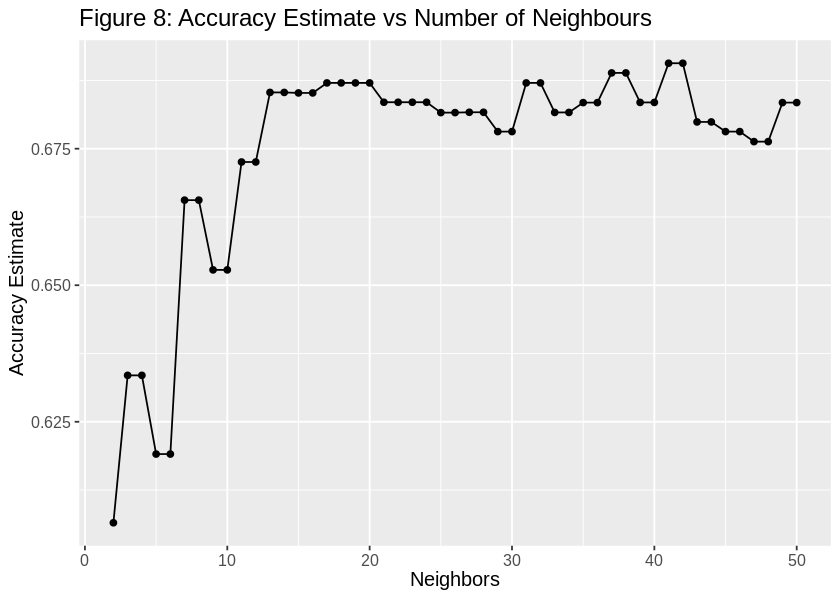

In [31]:
options(repr.plot.width = 7, repr.plot.height = 5) 
cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12)) +
  ggtitle("Figure 8: Accuracy Estimate vs Number of Neighbours")

cross_val_plot

We can now pull the best K to find what will give us the greatest accuracy. We can also just look at the graph above and see which neighbor has the highest accuracy.

In [32]:
best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

[1] 41

We know that the accuracy when using the training data is around 69% for K = 41 which is the greatest. Therefore, we can now build our final model with K = 41.

In [33]:
# building the model

# set the seed
set.seed(1) 
    
knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
       set_engine("kknn") |>
       set_mode("classification")

heart_fit <- workflow() |>
       add_recipe(heart_recipe) |>
       add_model(knn_spec_2) |>
       fit(data = heart_train)

heart_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(41,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.313059
Best kernel: rectangular
Best k: 41

## Results for classification using all predictors

We can now apply the final model to the testing set of data and see how it performs.

In [34]:
set.seed(1) 
heart_test_predictions <- predict(heart_fit, heart_test) |>
       bind_cols(heart_test)

We can now find the accuracy of our model on the testing set to determine how good the model is.

In [35]:
# accuracy
heart_prediction_accuracy <- heart_test_predictions |>
         metrics(truth = HeartDisease, estimate = .pred_class) |>
         filter(.metric != "kap") |>
         select(!.estimator)
heart_prediction_accuracy

.metric,.estimate
<chr>,<dbl>
accuracy,0.7005348


Table 12: Final model accuracy

We can now create a confusion matrix which tells us how many of the test set labels of each type are predicted correctly and incorrectly. This can help give us more detail about the kinds of mistakes the classifier tends to make.

In [36]:
# confusion matrix
heart_matrix <- heart_test_predictions |> 
       conf_mat(truth = HeartDisease, estimate = .pred_class)
heart_matrix

          Truth
Prediction no yes
       no  71  29
       yes 27  60

Table 13: Confusion matrix for K = 41

We can also find other performance metrics such as recall and precision to get a better sense of how the model performs. Again, we first check which label comes first.

In [37]:
heart_test_predictions |> pull(HeartDisease) |> levels()

[1] "no"  "yes"

Again, we can see that `no` comes before `yes`. Therefore, we use `event_level = "second"` while calculating recall and precision.

In [38]:
# performance metrics
heart_metrics <- metrics(heart_test_predictions, truth=HeartDisease, estimate=.pred_class) |>
    bind_rows(recall(heart_test_predictions, truth=HeartDisease, estimate=.pred_class, event_level="second")) |>
    bind_rows(precision(heart_test_predictions, truth=HeartDisease, estimate=.pred_class, event_level="second")) |>
    filter(.metric != "kap") |>
    select(!.estimator)

heart_metrics

.metric,.estimate
<chr>,<dbl>
accuracy,0.7005348
recall,0.6741573
precision,0.6896552


Figure 14: Performance metrics for K = 41

We can see that the accuracy of our model is 70.05% which is not that good for the medical industry. Our recall is around 67% and our precision is around 69% which are not that great either. We prefer a higher recall than precision here.

## Discussion:

### Summary

Through our methods, we have found that `Age` plays a significant role in heart disease patients, and as a person's age increases, they are more likely to develop heart disease. This can be seen in Figure 2 and Figure 3. In these graphs, `Age` is on the x-axis, while `RestingBP` or `Cholesterol` is on the y-axis. There is almost no correlation on the y-axis for this graph. However, on the x-axis, as soon as the `Age` passes 55 years, heart disease begins to be present. In Figure 4, there appears to be a moderate negative correlation, meaning that as `Age` increases on the x-axis and `MaxHR` decreases on the y-axis, more cases of heart disease present themselves. In the first graph without age on the x-axis, i.e. Figure 5, `MaxHR` is on the x-axis, and it is seen that once the heart rate passes ~130 beats per minute, heart disease becomes unlikely. Meanwhile, we can see that `Cholesterol` does not play that big of a role in the graph. In Figure 6, the previous idea that once the heart rate passes ~130 beats per minute, heart disease becomes unlikely, is supported. Also, `RestingBP` still plays almost no role. In Figure 7, there is very little correlation that can be seen between `RestingBP` and `Cholesterol` as there is a significant overlap of both points. These graphs make it clear that the only two factors that can be considered significant in predicting heart disease are `Age` and `MaxHR`. The accuracies, precisions and recalls that we found for each set also support this conclusion.

Through our results, we are able to see that our model is not entirely accurate and rather it has had 29 & 27 false negatives and false positives. Using the formula:

$${accuracy} = \frac{\mathrm{number \; of \; correct \; predictions}}{\mathrm{total \; number \; of \; predictions}} = \frac{60+71}{60+71+29+27} = 0.7005.$$
it is seen that the accuracy of our model is 70.05% which is not great but better than others. However, on the field of medical science we would want our classification model to be stronger as an inaccuarcy of 29.95% is very significant. In practice this would mean that out of 100 people nearly 30 people would be misdiagnosed. To improve this we could train our model with more data, we could also have the model use more cross validation. We can also see that a combination of all the predictors are better at classifying `HeartDisease` than just two predictors by themselves.

We can see that we have a higher precision than recall when using all predictors. In our case, we want a higher recall than precision because it is better to wrongly predict that a person has a heart disease compared to wrongly predicting a person does not have a heart disease.

The results found in the above study generally answer our initial research question, posed as "**can we predict if a patient has heart disease based on their age, resting blood pressure, serum cholesterol, and maximum resting heart rate?**". It seems that the measured `RestingBP` and `Cholesterol` plays little role in the presence of heart disease, while factors such as `Age` and `MaxHR`  play a significant role. While this does answer the research question, it is surprising to see that some factors played little role in determining the presence of heart disease (i.e. `RestingBP` and `Cholesterol` are traditionally viewed as factors potentially increasing the rate of heart disease). Further research or data analysis might be necessary to completely rule out the effects of these factors on heart health. 

The impact of these findings is profound for the treatment of heart disease. Knowing that these factors play a critical role in the presence of heart disease, doctors can be on the lookout for patients with concerning vitals. Furthermore, this research elucidates that `Cholesterol` and `RestingBP` play less of a role in the presence of heart disease, allowing doctors to be less concerned with certain patients. 

Understanding the results of our analysis, further questions can be drawn:

- "If `Cholesterol` and `RestingBP` don't increase the rates of heart disease, do they have any other effects on the body?"
- "Does the biological background (Northern European, Southern European, Subsaharan African, Indigenous, etc.) of an individual affect the rates of heart disease, potentially by increasing certain risk factors?"
- "If we can now identify patients with potential heart disease, what is the greatest corrective measure one can take to vastly improve their heart health?"
- "Does geographical location play a role in heart health? Are those in third world countries at higher risk or more predisposed towards heart disease than those in first world countries?"

Overall, this study effectively answered our research question, opening doors to improved patient care and potentially lowering mortality within the general population due to heart disease.

## References

Janosi,Andras, Steinbrunn,William, Pfisterer,Matthias, and Detrano,Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.

World Health Organization. (2023). *Cardiovascular Diseases*. World Health Organization. https://www.who.int/health-topics/cardiovascular-diseases#tab=tab_1